In [58]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import random
import fknn
from fknn import FuzzyKNN
from fcmeans import FCM
from sklearn.svm import SVC, SVR
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import logging
import json
from logging import FileHandler
import cloudpickle
import sys
import tqdm
from PIL import Image
import hashlib
import time
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd


#general testing functions for synthetic datasets
def gaussian(x, var):
    y = (np.e ** (-(((x-0.5)*2)**2)/(2*var)))
    return y

trapezoidal = lambda x: (2.3*x if x < 0.5 else -2.3*x+2.3) if (2.3*x if x < 0.5 else -2.3*x+2.3) < 1 else 1

X_test = np.linspace(0, 1, 1000)
X_test_g = np.array([x for x in X_test if (gaussian(x, np.var(X_test)) <= 0.1 or gaussian(x, np.var(X_test)) >= 0.9)])
X_test_t = np.array([x for x in X_test if (trapezoidal(x) <= 0.1 or trapezoidal(x) >= 0.9)])
X_test2_g = [np.array([x for x in X_test_g if x<0.2]),np.array([x for x in X_test_g if (x>=0.2 and x<0.8)]),np.array([x for x in X_test_g if x>0.8])]
X_test2_t = [np.array([x for x in X_test_t if x<0.2]),np.array([x for x in X_test_t if (x>=0.2 and x<0.8)]),np.array([x for x in X_test_t if x>0.8])]
X_test2 = [np.array([x for x in X_test if x<0.2]),np.array([x for x in X_test if (x>=0.2 and x<0.8)]),np.array([x for x in X_test if x>0.8])]
step = (X_test2[0][-1]-X_test2[0][0])/(len(X_test2[0])-1)


digit = 9

# MNIST datasets generation

In [13]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [14]:
input_path = './datasets/MNIST/mnist/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [166]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

In [167]:
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [168]:
X = np.append(X_train, X_test, axis=0)
Y = np.append(y_train, y_test, axis=0)

In [157]:
random.seed(42)
sample_train_5 = random.sample([x[0] for x in list(enumerate(Y)) if x[1] == 1], 500)
sample_train_rest = random.sample([x[0] for x in list(enumerate(Y)) if x[1] != 1], 500)
sample_train = sample_train_5 + sample_train_rest
random.shuffle(sample_train)

In [158]:
X_train = X[sample_train]
y_train = Y[sample_train]
X_test = np.delete(X, sample_train, axis=0)
y_test = np.delete(Y, sample_train, axis=0)

In [159]:
X_train = np.array([x.flatten() for x in X_train])
X_test = np.array([x.flatten() for x in X_test])

In [160]:
y_train = np.array([(0 if x != 1 else 1) for x in y_train])
y_test = np.array([(0 if x != 1 else 1) for x in y_test])

In [161]:
len(X_test)

69000

In [162]:
dataset = pd.DataFrame(columns=['X_train', 'X_test', 'y_train', 'y_test'])

In [163]:
dataset.X_test = pd.Series(X_test.tolist())
dataset.y_test = pd.Series(y_test)
dataset.X_train = pd.Series(X_train.tolist())
dataset.y_train = pd.Series(y_train)

In [164]:
dataset

,X_train,X_test,y_train,y_test
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,1
...,...,...,...,...
68995,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0
68996,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0
68997,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0
68998,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0


In [165]:
dataset.to_json("./datasets/MNIST/mnist_full.json")

In [166]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

In [167]:
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [168]:
X = np.append(X_train, X_test, axis=0)
Y = np.append(y_train, y_test, axis=0)

In [173]:
X = np.array([x.flatten() for x in X])

In [176]:
dataset = pd.DataFrame(columns=['X','y'])

In [177]:
dataset.X = pd.Series(X.tolist())
dataset.y = pd.Series(Y)

In [178]:
dataset

,X,y
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
...,...,...
69995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
69996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
69997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
69998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5


In [179]:
dataset.to_json("./datasets/MNIST/mnist_full.json")

## CNN feature extraction

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

2024-03-09 17:38:52.519702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 17:38:53.531910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = Sequential()
# add the pretrained model
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

# set resnet layers not trainable
model.layers[0].trainable=False
model.summary()

2024-03-09 17:38:55.148371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 17:38:55.285426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 17:38:55.285501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 17:38:55.287832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 17:38:55.287887: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [3]:
dataset = pd.read_json('datasets/MNIST/digit-9/mnist_full.json')

In [4]:
len(dataset.X_train[0])

784

In [5]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [6]:
X_train = X_train.reshape((X_train.shape[0], 28, 28))
X_test = X_test.reshape((X_test.shape[0], 28, 28))

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = np.stack((X_train,)*3, axis=-1)
X_test = np.stack((X_test,)*3, axis=-1)

In [7]:
X_tr = model.predict(X_train)
X_ts = model.predict(X_test)

2024-03-09 17:23:19.328462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-03-09 17:23:19.382262: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Running ptxas --version returned -1
2024-03-09 17:23:19.403804: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: ptxas exited with non-zero error code -1, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-09 17:23:19.632023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/2157 [..............................] - ETA: 35s

2024-03-09 17:23:20.737814: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 649152000 exceeds 10% of free system memory.
2024-03-09 17:23:21.094221: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 649152000 exceeds 10% of free system memory.


2157/2157 [==============================] - 14s 7ms/step


2024-03-09 17:23:36.325219: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 565248000 exceeds 10% of free system memory.


In [8]:
dataset = pd.DataFrame(columns=['X_train', 'X_test', 'y_train', 'y_test'])

In [9]:
pca = PCA(n_components=784)

In [10]:
dataset.X_test = pd.Series(pca.fit_transform(X_ts).tolist())
dataset.y_test = pd.Series(y_test)
dataset.X_train = pd.Series(pca.fit_transform(X_tr).tolist())
dataset.y_train = pd.Series(y_train)

In [11]:
dataset

,X_train,X_test,y_train,y_test
0,"[-52.0404052734375, -1.1849124431610107, 0.974...","[51.4664306640625, -38.48853302001953, -21.142...",0.0,0
1,"[-1.45470130443573, -3.422642230987549, -4.773...","[-31.737510681152344, 5.920137405395508, 12.05...",1.0,0
2,"[-1.6065526008605957, 20.285364151000977, -19....","[-27.712858200073242, 4.088764190673828, -26.9...",1.0,0
3,"[14.760562896728516, -10.216889381408691, -3.7...","[86.68650817871094, 24.9345703125, 1.635362863...",0.0,0
4,"[-4.936356067657471, -4.133682727813721, -28.4...","[-17.374677658081055, -0.9476553201675415, 2.7...",0.0,1
...,...,...,...,...
68995,NaN,"[54.04206848144531, -18.00141716003418, 11.087...",NaN,0
68996,NaN,"[-13.508169174194336, -3.6055686473846436, 24....",NaN,0
68997,NaN,"[16.879465103149414, 4.630447864532471, -16.47...",NaN,0
68998,NaN,"[-7.188337802886963, 0.5320671796798706, 6.752...",NaN,0


In [12]:
dataset.to_json("./datasets/MNIST/digit-9/mnist_full_cnn.json")

In [3]:
dataset = pd.read_json('datasets/MNIST/all-digits/mnist_full.json')

In [4]:
X = np.array(dataset.X.to_list())
y = np.array(dataset.y.to_list())

In [5]:
X = X.reshape((X.shape[0], 28, 28))

X = X.astype('float32')

X = np.stack((X,)*3, axis=-1)

In [6]:
X_t = model.predict(X)

2024-03-09 17:39:04.818598: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 658560000 exceeds 10% of free system memory.
2024-03-09 17:39:05.448025: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 658560000 exceeds 10% of free system memory.
2024-03-09 17:39:06.223870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-03-09 17:39:06.451598: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Running ptxas --version returned -1
2024-03-09 17:39:06.489351: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: ptxas exited with non-zero error code -1, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-09 17:39:06.598554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_

2188/2188 [==============================] - 16s 7ms/step


In [7]:
dataset = pd.DataFrame(columns=['X', 'y'])

In [8]:
pca = PCA(n_components=784)

In [9]:
dataset.X = pd.Series(pca.fit_transform(X_t).tolist())
dataset.y = pd.Series(y)

In [10]:
dataset

,X,y
0,"[51.71218490600586, -38.35850524902344, -21.20...",5
1,"[-31.58961296081543, 5.7563796043396, 11.96757...",0
2,"[-27.56419563293457, 3.9507994651794434, -26.8...",4
3,"[86.75652313232422, 25.1878719329834, 1.243247...",1
4,"[-17.260393142700195, -1.0024819374084473, 2.7...",9
...,...,...
69995,"[54.25825119018555, -17.840784072875977, 11.02...",2
69996,"[-13.30836296081543, -3.681253433227539, 24.21...",3
69997,"[17.052690505981445, 4.639980316162109, -16.40...",4
69998,"[-7.0294508934021, 0.4811342656612396, 6.87559...",5


In [11]:
dataset.to_json("./datasets/MNIST/all-digits/mnist_full_cnn.json")

# Synthetic datasets generation

In [9]:
def gaussian(x, var):
    y = (np.e ** (-(((x-0.5)*2)**2)/(2*var)))
    return y

In [103]:
dataset = pd.DataFrame(columns=["X", "y", "y_crisp"])

In [104]:
dataset["X"] = np.random.uniform(0,1,4000)

var = np.var(dataset["X"])

for index in dataset.index:

    val = gaussian(dataset.loc[index, "X"], var) 
    
    dataset.loc[index, "y"] = val if (val >= 0.9 or val <= 0.1) else np.nan
    dataset.loc[index, "y_crisp"] = 1 if val >= 0.9 else 0


dataset = dataset.dropna()

In [105]:
dataset

,X,y,y_crisp
4,0.137777,0.039864,0
8,0.895814,0.02133,0
10,0.969089,0.004498,0
11,0.168475,0.067255,0
12,0.112038,0.02481,0
...,...,...,...
3990,0.907733,0.016859,0
3992,0.012810,0.00294,0
3993,0.135991,0.038614,0
3994,0.978708,0.003596,0


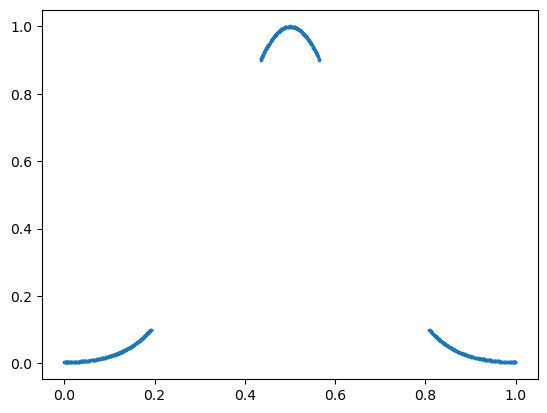

In [107]:
plt.scatter(dataset.X, dataset.y, s=2)
plt.show()

In [10]:
X_test = np.linspace(0, 1, 1000)
X_test = np.array([x for x in X_test if (gaussian(x, np.var(X_test)) <= 0.1 or gaussian(x, np.var(X_test)) >= 0.9)])
X_test2 = [np.array([x for x in X_test if x<0.2]),np.array([x for x in X_test if (x>=0.2 and x<0.8)]),np.array([x for x in X_test if x>0.8])]
y_test_crisp = [(0 if x < 0.5 else 1) for x in gaussian(X_test, np.var(X_test))]
step = (X_test2[0][-1]-X_test2[0][0])/(len(X_test2[0])-1)

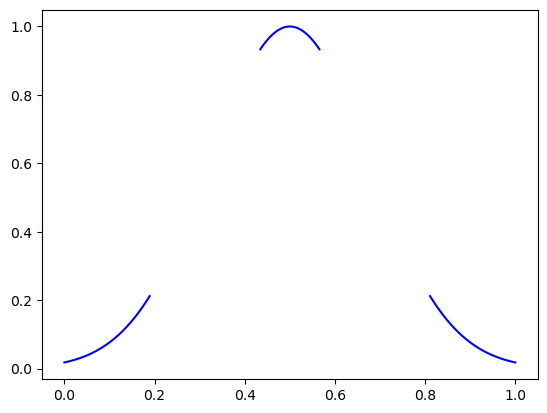

In [286]:
plt.plot(X_test2[0], gaussian(X_test2[0], np.var(X_test)), color="blue")
plt.plot(X_test2[1], gaussian(X_test2[1], np.var(X_test)), color="blue")
plt.plot(X_test2[2], gaussian(X_test2[2], np.var(X_test)), color="blue")
plt.show()

In [ ]:
#dataset.to_csv('datasets/synthetic_datasets/gaussian.csv')

In [28]:
trapezoidal = lambda x: (2.3*x if x < 0.5 else -2.3*x+2.3) if (2.3*x if x < 0.5 else -2.3*x+2.3) < 1 else 1

In [74]:
dataset = pd.DataFrame(columns=["X", "y", "y_crisp"])

In [75]:
dataset["X"] = np.random.uniform(0,1,6700)

for index in dataset.index:

    val = trapezoidal(dataset.loc[index, "X"]) 
    
    dataset.loc[index, "y"] = val if (val >= 0.9 or val <= 0.1) else np.nan
    dataset.loc[index, "y_crisp"] = 1 if val >= 0.9 else 0


dataset = dataset.dropna()

In [76]:
dataset

,X,y,y_crisp
0,0.560043,1,1
2,0.482445,1,1
8,0.475447,1,1
11,0.402165,0.92498,1
25,0.971340,0.065919,0
...,...,...,...
6683,0.013306,0.030603,0
6689,0.024708,0.056828,0
6695,0.009971,0.022933,0
6697,0.961439,0.088691,0


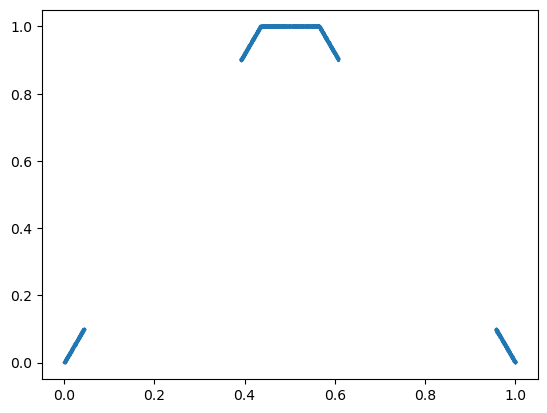

In [77]:
plt.scatter(dataset.X, dataset.y, s=2)
plt.show()

In [78]:
X_test = np.linspace(0, 1, 1000)
X_test = np.array([x for x in X_test if (trapezoidal(x) <= 0.1 or trapezoidal(x) >= 0.9)])
X_test2 = [np.array([x for x in X_test if x<0.2]),np.array([x for x in X_test if (x>=0.2 and x<0.8)]),np.array([x for x in X_test if x>0.8])]
y_test_crisp = [(0 if x < 0.5 else 1) for x in [trapezoidal(x) for x in X_test]]
step = (X_test2[0][-1]-X_test2[0][0])/(len(X_test2[0])-1)

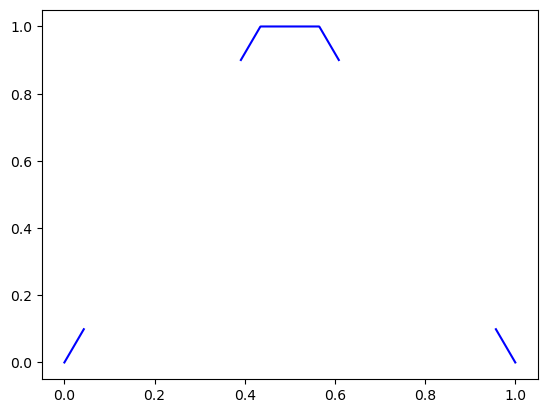

In [79]:
plt.plot(X_test2[0], [trapezoidal(x) for x in X_test2[0]], color="blue")
plt.plot(X_test2[1], [trapezoidal(x) for x in X_test2[1]], color="blue")
plt.plot(X_test2[2], [trapezoidal(x) for x in X_test2[2]], color="blue")
plt.show()

In [80]:
#dataset.to_csv('datasets/synthetic_datasets/trapezoidal_bigger.csv')

# Datasets and pre-trained models download (~3GB)

In [ ]:
!pip3 install git+https://github.com/Juvenal-Yescas/mediafire-dl

In [ ]:
import mediafire_dl

url = 'https://www.mediafire.com/file/t7h7kes7lgl2l5y/data.tar.gz/file'
output = 'data.tar.gz'
mediafire_dl.download(url, output, quiet=False)

In [ ]:
!tar -xzvf data.tar.gz

In [ ]:
!pip install cloudpickle

# Model logging

In [2]:
class JsonFormatter(logging.Formatter):

    @staticmethod
    def find(s, ch):
        return [i for i, ltr in enumerate(s) if ltr == ch]

    def format(self, record) -> str:
        
        log_record = {
            'timestamp': self.formatTime(record),
            'model': record.getMessage()
        }
        
        if record.exc_info:
            log_record['exception'] = self.formatException(record.exc_info)

        output = json.dumps(log_record) + ','

        output = output[:self.find(output, '"')[-1]] + '' + output[self.find(output, '"')[-1]+1:]
        output = output[:self.find(output, '"')[-1]] + '' + output[self.find(output, '"')[-1]+1:]

        output = output.replace("'",'"')
        
        return output

json_handler = FileHandler('test_logs.log')
json_handler.setLevel(logging.INFO)
json_formatter = JsonFormatter()
json_handler.setFormatter(json_formatter)

logger = logging.getLogger(__name__)
logger.addHandler(json_handler)
logging.getLogger().setLevel(logging.INFO)

In [3]:
def log_model(model=None, score=-1, acc=-1, std=-1, model_name='', serialize=False, dataset=''):

    if not isinstance(model, list):
        json_dict = { 'model_name' : model.__repr__() if (model_name == '') else model_name }
    else:
        json_dict = { 'model_name' : 'Unidentified model' if (model_name == '') else model_name }
    
    if score != -1:
        json_dict['score'] = score
    if acc != -1:
        json_dict['acc'] = acc
    if std != -1:
        json_dict['std'] = std
        
    if serialize == True:
        try:
    
            dir_name = hashlib.md5(int(time.time()*1000).to_bytes(8, 'big', signed=True)).hexdigest()[:10]
            os.mkdir(f'./objects/{dir_name}')
            
            if isinstance(model, list):
    
                for i,m in enumerate(model):
    
                    filehandler = open(f"objects/{dir_name}/{i+1}.obj","wb")
                    cloudpickle.dump(m, filehandler)
                    filehandler.close()
                    json_dict['obj'] = f'objects/{dir_name}/1.obj'
                
            else:
                filehandler = open(f"objects/{dir_name}/1.obj","wb")
                cloudpickle.dump(model, filehandler)
                filehandler.close()
                json_dict['obj'] = f'objects/{dir_name}/1.obj'
        except Exception as e: 
            #print("Error with object serialization")
            print(e)
            
    if dataset != '':
        json_dict['dataset'] = dataset

    return json_dict

In [5]:
logger.info("{'model_name':'test'}")

# <span style="color:red"> mulearn

In [6]:
from importlib import reload

import __init__
import distributions
import kernel
import fuzzifier
import optimization

reload(__init__)
reload(distributions)
reload(kernel)
reload(fuzzifier)
reload(optimization)

from __init__ import *
from distributions import *
from kernel import *
from fuzzifier import *
from optimization import *

tensorflow not available
torch not available
tensorflow not available
torch not available


## Synthetic datasets

### Gaussian

In [2]:
dataset = pd.read_csv("datasets/synthetic_datasets/gaussian.csv").drop('Unnamed: 0', axis=1)

In [5]:
parameters = {'c' : [x for x in np.logspace(-2,2,5)],
              'k' : [GaussianKernel(sigma=x) for x in np.logspace(-2,2,5)],
              'fuzzifier' : [ExponentialFuzzifier(profile='fixed'),
                             ExponentialFuzzifier(profile='infer')] +
                             [ExponentialFuzzifier(profile='alpha',alpha=x) for x in np.logspace(-2,0,3)]}

model = FuzzyInductor(solver=GurobiSolver(adjustment='auto'))

clf = GridSearchCV(model, parameters, verbose=0, n_jobs=-1, refit=True)

In [ ]:
clf.fit(np.array(dataset.X).reshape(-1,1), dataset.y)

In [7]:
model = clf.best_estimator_
model.fit(np.array(dataset.X).reshape(-1,1), dataset.y)

FuzzyInductor(c=10.0, k=GaussianKernel(sigma=10.0), f=ExponentialFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))

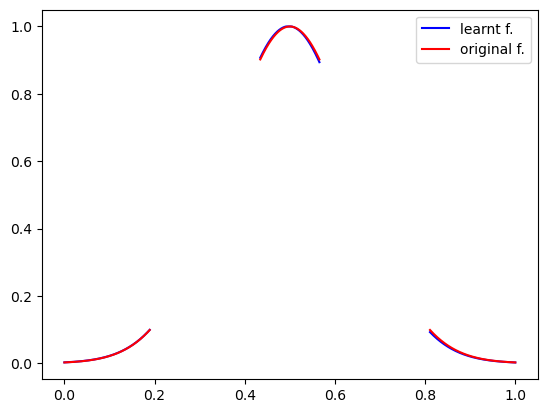

In [12]:
plt.plot(X_test2_g[0], model.predict(X_test2_g[0].reshape(-1,1)), color="blue", label="learnt f.")
plt.plot(X_test2_g[1], model.predict(X_test2_g[1].reshape(-1,1)), color="blue")
plt.plot(X_test2_g[2], model.predict(X_test2_g[2].reshape(-1,1)), color="blue")

plt.plot(X_test2_g[0], gaussian(X_test2_g[0], np.var(X_test)), color="red", label="original f.")
plt.plot(X_test2_g[1], gaussian(X_test2_g[1], np.var(X_test)), color="red")
plt.plot(X_test2_g[2], gaussian(X_test2_g[2], np.var(X_test)), color="red")

plt.legend(loc="upper right")

plt.show()

In [13]:
err = np.sum(step*(np.abs(np.array(model.predict(X_test.reshape(-1,1))) - gaussian(X_test, np.var(X_test)))))
err

0.004601664822032125

In [14]:
logger.info(log_model(model=model, score=err, dataset='gaussian', serialize=True))

In [8]:
f = lambda x : x**2
X = np.linspace(0,10,100000)
print("Integral:", ((10**3)/3))
print("Integral estim.", np.sum((X[-1]-X[0])/(len(X)-1)*np.array(f(X))))

Integral: 333.3333333333333
Integral estim. 333.3383334000009


### Trapezoidal

In [15]:
dataset = pd.read_csv("datasets/synthetic_datasets/trapezoidal.csv").drop('Unnamed: 0', axis=1)

In [16]:
parameters_linear = {'c' : [x for x in np.logspace(-2,2,5)],
                     'k' : [LinearKernel()],
                     'fuzzifier' : [LinearFuzzifier(profile='infer'), LinearFuzzifier(profile='fixed')]}

parameters_polynomial = {'c' : [x for x in np.logspace(-2,2,5)],
                         'k' : [PolynomialKernel(degree=x) for x in (2,3,4)],
                         'fuzzifier' : [LinearFuzzifier(profile='infer'), LinearFuzzifier(profile='fixed')]}

parameters = [parameters_linear, parameters_polynomial]

model = FuzzyInductor(solver=GurobiSolver(adjustment='auto'))

clf = GridSearchCV(model, parameters, verbose=0, n_jobs=-1, refit=True)

In [ ]:
clf.fit(np.array(dataset.X).reshape(-1,1), dataset.y)

In [18]:
model = clf.best_estimator_
model.fit(np.array(dataset.X).reshape(-1,1), dataset.y)

FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))

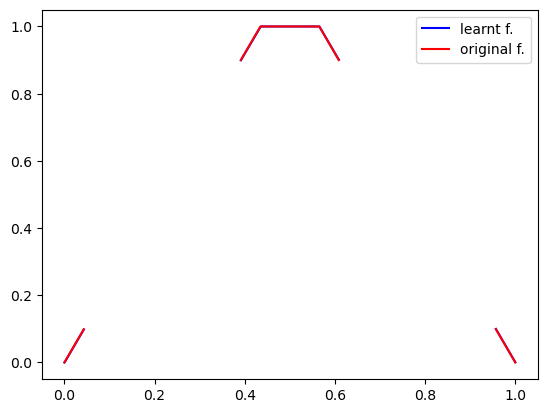

In [19]:
plt.plot(X_test2_t[0], model.predict(X_test2_t[0].reshape(-1,1)), color="blue", label="learnt f.")
plt.plot(X_test2_t[1], model.predict(X_test2_t[1].reshape(-1,1)), color="blue")
plt.plot(X_test2_t[2], model.predict(X_test2_t[2].reshape(-1,1)), color="blue")

plt.plot(X_test2_t[0], [trapezoidal(x) for x in X_test2_t[0]], color="red", label="original f.")
plt.plot(X_test2_t[1], [trapezoidal(x) for x in X_test2_t[1]], color="red")
plt.plot(X_test2_t[2], [trapezoidal(x) for x in X_test2_t[2]], color="red")

plt.legend(loc="upper right")

plt.show()

In [20]:
err = np.sum(step*(np.abs(np.array(model.predict(X_test.reshape(-1,1))) - [trapezoidal(x) for x in X_test])))
err

0.0007379405464744573

In [21]:
logger.info(log_model(model=model, score=err, dataset='trapezoidal', serialize=True))

## Breast cancer

In [6]:
dataset_bc = load_breast_cancer()

In [7]:
parameters_linear = {'c' : [x for x in np.logspace(-2,2,5)],
                     'k' : [LinearKernel()],
                     'fuzzifier' : [LinearFuzzifier(profile='infer'), LinearFuzzifier(profile='fixed')]}

parameters_polynomial = {'c' : [x for x in np.logspace(-2,2,5)],
                         'k' : [PolynomialKernel(degree=x) for x in (2,3,4)],
                         'fuzzifier' : [LinearFuzzifier(profile='infer'), LinearFuzzifier(profile='fixed')]}

parameters_gaussian = {'c' : [x for x in np.logspace(-2,2,5)],
                       'k' : [GaussianKernel(sigma=x) for x in np.logspace(-2,2,5)],
                       'fuzzifier' : [ExponentialFuzzifier(profile='fixed'), ExponentialFuzzifier(profile='infer')] +
                                     [ExponentialFuzzifier(profile='alpha',alpha=x) for x in np.logspace(-2,0,3)]}

In [8]:
model = FuzzyInductor(solver=GurobiSolver(adjustment='auto'))

In [ ]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)

best_models = []

for train, test in tqdm.tqdm(outer_cv.split(dataset_bc.data, dataset_bc.target)):

    clf = GridSearchCV(estimator=model, param_grid=[parameters_linear, 
                                                    parameters_polynomial, 
                                                    parameters_gaussian], 
                       cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(dataset_bc.data[train], dataset_bc.target[train])

    m = clf.best_estimator_

    best_acc = 0
    for alpha in np.linspace(0.1,0.9,9):
        acc = accuracy_score(y_pred=m.predict(dataset_bc.data[train], alpha=alpha), y_true=dataset_bc.target[train])
        if acc > best_acc:
            best_alpha = alpha

    outer_cv_params.append(m.__repr__())
    acc_score = accuracy_score(y_pred=m.predict(dataset_bc.data[test], alpha=best_alpha), y_true=dataset_bc.target[test])
    outer_cv_scores.append(acc_score)
    
    best_models.append((m, acc_score, best_alpha))

score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]

best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

In [10]:
score

[0.9049681726439994, 0.04396131014634527]

In [11]:
outer_cv_scores

[0.9385964912280702,
 0.9298245614035088,
 0.9473684210526315,
 0.8771929824561403,
 0.831858407079646]

In [12]:
outer_cv_params

['FuzzyInductor(c=100.0, k=PolynomialKernel(2), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=100.0, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=100.0, k=PolynomialKernel(2), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=100.0, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=100.0, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))']

In [13]:
best_models

[(FuzzyInductor(c=100.0, k=PolynomialKernel(2), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.9473684210526315,
  0.9),
 (FuzzyInductor(c=100.0, k=PolynomialKernel(2), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.9385964912280702,
  0.9),
 (FuzzyInductor(c=100.0, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.9298245614035088,
  0.9),
 (FuzzyInductor(c=100.0, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.8771929824561403,
  0.9),
 (FuzzyInductor(c=100.0, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.831858407079646,
  0.9)]

In [14]:
logger.info(log_model(model=best_models, model_name='mulearn', acc=score[0], std=score[1], dataset='breast_cancer', serialize=True))

In [82]:
X_train, X_test, y_train, y_test = train_test_split(dataset_bc.data, dataset_bc.target, random_state=42)

In [81]:
model = FuzzyInductor(c=100.0, k=LinearKernel(), fuzzifier=LinearFuzzifier(profile='infer'), solver=GurobiSolver(adjustment='auto'))

In [83]:
model.fit(X_train, y_train)

FuzzyInductor(c=100.0, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))

In [85]:
[accuracy_score(y_pred=model.predict(X_test, alpha=x), y_true=y_test) for x in np.linspace(0.1,0.9,9)]

[0.965034965034965,
 0.965034965034965,
 0.972027972027972,
 0.965034965034965,
 0.965034965034965,
 0.951048951048951,
 0.9370629370629371,
 0.9020979020979021,
 0.8811188811188811]

In [86]:
res = model.predict(X_test, alpha=0.3)

In [87]:
wrong_classified = []

In [88]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [89]:
wrong_classified

[20, 58, 77, 82]

In [93]:
[(i,x) for (i,x) in enumerate(model.predict(X_test)) if 0.4<=x<=0.6]

[(47, 0.5088691257572919),
 (82, 0.5561756989894904),
 (112, 0.5075429936388411),
 (120, 0.5416204248135945)]

## MNIST

In [21]:
dataset = pd.read_json('datasets/MNIST/digit-2/mnist_full.json')

In [22]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [23]:
parameters_linear = {'c' : [x for x in np.logspace(-2,2,5)],
                     'k' : [LinearKernel()],
                     'fuzzifier' : [LinearFuzzifier(profile='infer'), LinearFuzzifier(profile='fixed')]}

parameters_polynomial = {'c' : [x for x in np.logspace(-2,2,5)],
                         'k' : [PolynomialKernel(degree=x) for x in (2,3,4)],
                         'fuzzifier' : [LinearFuzzifier(profile='infer'), LinearFuzzifier(profile='fixed')]}

parameters_gaussian = {'c' : [x for x in np.logspace(-2,2,5)],
                       'k' : [GaussianKernel(sigma=x) for x in np.logspace(-2,2,5)],
                       'fuzzifier' : [ExponentialFuzzifier(profile='fixed'), ExponentialFuzzifier(profile='infer')] +
                                     [ExponentialFuzzifier(profile='alpha',alpha=x) for x in np.logspace(-2,0,3)]}

params = [parameters_linear, parameters_polynomial, parameters_gaussian]

In [24]:
model = FuzzyInductor(solver=GurobiSolver(adjustment='auto'))

In [10]:
unique, counts = np.unique(y_train[800:1000], return_counts=True)
dict(zip(unique, counts))

{0: 100, 1: 100}

In [ ]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)

best_models = []

for train, test in tqdm.tqdm(outer_cv.split(X_train, y_train)):

    clf = GridSearchCV(estimator=model, param_grid=params, 
                       cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(X_train[train], y_train[train])

    m = clf.best_estimator_
    
    best_acc = 0
    for alpha in np.linspace(0.1,0.9,9):
        acc = accuracy_score(y_pred=m.predict(X_train[train], alpha=alpha), y_true=y_train[train])
        if acc > best_acc:
            best_alpha = alpha

    outer_cv_params.append(m.__repr__())
    acc_score = accuracy_score(y_pred=m.predict(X_train[test], alpha=best_alpha), y_true=y_train[test])
    outer_cv_scores.append(acc_score)

    best_models.append((m, acc_score, best_alpha))
    

score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

In [26]:
score

[0.873, 0.016309506430300102]

In [27]:
outer_cv_scores

[0.86, 0.89, 0.895, 0.855, 0.865]

In [28]:
outer_cv_params

['FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))']

In [29]:
best_models

[(FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.895,
  0.9),
 (FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.89,
  0.9),
 (FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.865,
  0.9),
 (FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.86,
  0.9),
 (FuzzyInductor(c=0.1, k=LinearKernel(), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto)),
  0.855,
  0.9)]

In [ ]:
logger.info(log_model(model=best_models, model_name='mulearn', acc=score[0], std=score[1], dataset='MNIST_FULL_2', serialize=True))

In [96]:
model = FuzzyInductor(c=1, k=PolynomialKernel(degree=2), fuzzifier=LinearFuzzifier(profile='infer'), solver=GurobiSolver(adjustment='auto'))

In [97]:
model.fit(X_train, y_train)

FuzzyInductor(c=1, k=PolynomialKernel(2), f=LinearFuzzifier(profile=infer), solver=GurobiSolver(, adjustment=auto))

In [40]:
[accuracy_score(y_pred=model.predict(X_test, alpha=x), y_true=y_test) for x in np.linspace(0.1,0.9,9)]


[0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667,
 0.8666666666666667]

In [41]:
res = model.predict(X_test, alpha=0.5)

In [42]:
wrong_classified = []

In [43]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [44]:
wrong_classified

[8,
 15,
 21,
 40,
 45,
 46,
 48,
 49,
 62,
 63,
 68,
 81,
 87,
 89,
 94,
 102,
 103,
 105,
 116,
 118,
 125,
 134,
 137,
 146,
 161,
 162,
 168,
 173,
 195,
 202,
 212,
 219,
 233,
 235,
 237,
 253,
 263,
 272,
 283,
 294]

In [ ]:
for index in wrong_classified:
    arr = X_test[index].reshape(28,28)
    img = Image.fromarray(np.uint8(arr) , 'L')
    display(img.resize((200, 200)))

In [98]:
[(i,x) for (i,x) in enumerate(model.predict(X_test)) if 0.4<=x<=0.6]

[]

### ResNet50 inputs

In [7]:
dataset = pd.read_json("./datasets/MNIST/digit-2/mnist_full_cnn.json")

In [8]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [9]:
model = FuzzyInductor(solver=GurobiSolver(adjustment='auto'))

In [10]:
parameters_linear = {'c' : [x for x in np.logspace(-2,2,5)],
                     'k' : [LinearKernel()],
                     'fuzzifier' : [LinearFuzzifier(profile='infer'), LinearFuzzifier(profile='fixed')]}

parameters_polynomial = {'c' : [x for x in np.logspace(-2,2,5)],
                         'k' : [PolynomialKernel(degree=x) for x in (2,3,4)],
                         'fuzzifier' : [LinearFuzzifier(profile='infer'), LinearFuzzifier(profile='fixed')]}

parameters_gaussian = {'c' : [x for x in np.logspace(-2,2,5)],
                       'k' : [GaussianKernel(sigma=x) for x in np.logspace(-2,2,5)],
                       'fuzzifier' : [ExponentialFuzzifier(profile='fixed'), ExponentialFuzzifier(profile='infer')] +
                                     [ExponentialFuzzifier(profile='alpha',alpha=x) for x in np.logspace(-2,0,3)]}

params = [parameters_linear, parameters_polynomial, parameters_gaussian]

In [ ]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)

best_models = []

for train, test in tqdm.tqdm(outer_cv.split(X_train, y_train)):

    clf = GridSearchCV(estimator=model, param_grid=params, 
                       cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(X_train[train], y_train[train])

    m = clf.best_estimator_
    
    best_acc = 0
    for alpha in np.linspace(0.1,0.9,9):
        acc = accuracy_score(y_pred=m.predict(X_train[train], alpha=alpha), y_true=y_train[train])
        if acc > best_acc:
            best_alpha = alpha

    outer_cv_params.append(m.__repr__())
    acc_score = accuracy_score(y_pred=m.predict(X_train[test], alpha=best_alpha), y_true=y_train[test])
    outer_cv_scores.append(acc_score)

    best_models.append((m, acc_score, best_alpha))


score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

In [20]:
logger.info(log_model(model=best_models, model_name='mulearn', acc=score[0], std=score[1], dataset='MNIST_FULL_CNN_2', serialize=True))

In [17]:
score

[0.8480000000000001, 0.022494443758404006]

In [14]:
outer_cv_scores

[0.885, 0.82, 0.85, 0.83, 0.855]

In [15]:
outer_cv_params

['FuzzyInductor(c=100.0, k=GaussianKernel(sigma=100.0), f=ExponentialFuzzifier(), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=100.0, k=GaussianKernel(sigma=100.0), f=ExponentialFuzzifier(), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=1.0, k=LinearKernel(), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=1.0, k=LinearKernel(), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=auto))',
 'FuzzyInductor(c=10.0, k=LinearKernel(), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=auto))']

In [ ]:
best_models

In [102]:
model = FuzzyInductor(c=1.0, k=GaussianKernel(sigma=100.0), fuzzifier=ExponentialFuzzifier(profile='alpha', alpha=0.1), solver=GurobiSolver(adjustment='auto'))

In [103]:
model.fit(X_train, y_train)

10.0-percentile is 0.0010405902359354458


FuzzyInductor(c=1.0, k=GaussianKernel(sigma=100.0), f=ExponentialFuzzifier(profile=alpha, alpha=0.1), solver=GurobiSolver(, adjustment=auto))

In [50]:
[accuracy_score(y_pred=model.predict(X_test, alpha=x), y_true=y_test) for x in np.linspace(0.1,0.9,9)]

[0.8966666666666666,
 0.8933333333333333,
 0.8933333333333333,
 0.8933333333333333,
 0.8933333333333333,
 0.8966666666666666,
 0.8966666666666666,
 0.9,
 0.8966666666666666]

In [51]:
res = model.predict(X_test, alpha=0.8)

In [52]:
wrong_classified = []

In [53]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [54]:
wrong_classified

[8,
 15,
 49,
 60,
 63,
 88,
 102,
 103,
 104,
 106,
 112,
 114,
 115,
 119,
 129,
 131,
 161,
 168,
 173,
 202,
 204,
 205,
 220,
 227,
 232,
 234,
 236,
 272,
 284,
 291]

In [ ]:
for index in wrong_classified:
    arr = np.array(pd.read_json("./mnist.json").X_test.dropna().to_list())[index].reshape(28,28)
    img = Image.fromarray(np.uint8(arr) , 'L')
    display(img.resize((200, 200)))

In [104]:
[(i,x) for (i,x) in enumerate(model.predict(X_test)) if 0.4<=x<=0.6]

[(254, 0.5684068308197364)]

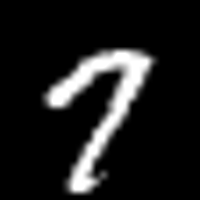

In [105]:
arr = np.array(pd.read_json("./mnist.json").X_test.dropna().to_list())[254].reshape(28,28)
img = Image.fromarray(np.uint8(arr) , 'L')
display(img.resize((200, 200)))

# <span style="color:red"> Fuzzy KNN

## Synthetic datasets

### Gaussian

In [22]:
dataset = pd.read_csv("datasets/synthetic_datasets/gaussian.csv").drop('Unnamed: 0', axis=1)

In [23]:
model = FuzzyKNN(k=11)
model.fit(np.array(dataset.X).reshape(-1,1), list(dataset.y_crisp))

FuzzyKNN(k=11)

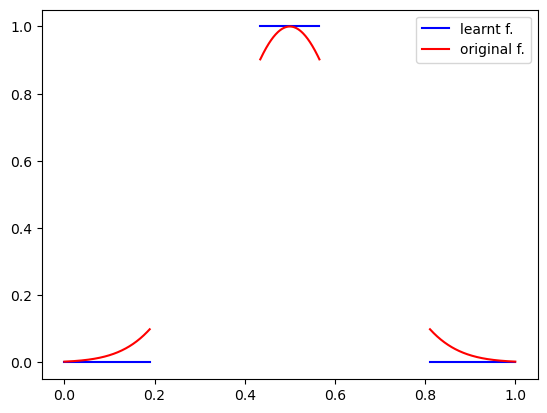

In [24]:
plt.plot(X_test2_g[0], [y[0] for y in model.predict(X_test2_g[0])], color="blue", label="learnt f.")
plt.plot(X_test2_g[1], [y[0] for y in model.predict(X_test2_g[1])], color="blue")
plt.plot(X_test2_g[2], [y[0] for y in model.predict(X_test2_g[2])], color="blue")

plt.plot(X_test2_g[0], gaussian(X_test2_g[0], np.var(X_test)), color="red", label="original f.")
plt.plot(X_test2_g[1], gaussian(X_test2_g[1], np.var(X_test)), color="red")
plt.plot(X_test2_g[2], gaussian(X_test2_g[2], np.var(X_test)), color="red")

plt.legend(loc="upper right")

plt.show()

In [26]:
err = np.sum(step*(np.abs(np.array([y[0] for y in model.predict(X_test)]) - gaussian(X_test, np.var(X_test)))))
err

0.15321809785868928

In [28]:
logger.info(log_model(model=model, score=err, dataset='gaussian', serialize=True))

### Trapezoidal

In [29]:
dataset = pd.read_csv("datasets/synthetic_datasets/trapezoidal.csv").drop('Unnamed: 0', axis=1)

In [30]:
model = FuzzyKNN(k=11)
model.fit(np.array(dataset.X).reshape(-1,1), list(dataset.y_crisp))

FuzzyKNN(k=11)

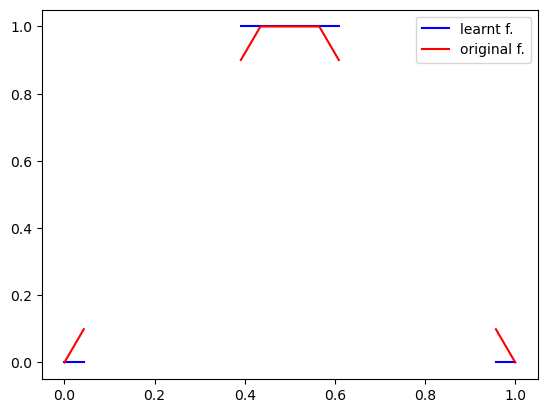

In [32]:
plt.plot(X_test2_t[0], [y[0] for y in model.predict(X_test2_t[0])], color="blue", label="learnt f.")
plt.plot(X_test2_t[1], [y[0] for y in model.predict(X_test2_t[1])], color="blue")
plt.plot(X_test2_t[2], [y[0] for y in model.predict(X_test2_t[2])], color="blue")

plt.plot(X_test2_t[0], [trapezoidal(x) for x in X_test2_t[0]], color="red", label="original f.")
plt.plot(X_test2_t[1], [trapezoidal(x) for x in X_test2_t[1]], color="red")
plt.plot(X_test2_t[2], [trapezoidal(x) for x in X_test2_t[2]], color="red")

plt.legend(loc="upper right")

plt.show()

In [33]:
err = np.sum(step*(np.abs(np.array([y[0] for y in model.predict(X_test)]) - [trapezoidal(x) for x in X_test])))
err

0.2173919665411157

In [34]:
logger.info(log_model(model=model, score=err, dataset='trapezoidal', serialize=True))

## Breast cancer

In [95]:
dataset_bc = load_breast_cancer()

In [96]:
parameters = {'k' : [3,5,7,9,11,21,31,41,51]}

In [97]:
model = FuzzyKNN()

In [98]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

for train, test in tqdm.tqdm(outer_cv.split(dataset_bc.data, dataset_bc.target)):

    clf = GridSearchCV(estimator=model, param_grid= parameters, cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(dataset_bc.data[train], dataset_bc.target[train])

    m = clf.best_estimator_
    
    outer_cv_params.append(m.__repr__())
    acc_score = m.score(dataset_bc.data[test], dataset_bc.target[test])
    outer_cv_scores.append(acc_score)

    best_models.append((m, acc_score))

score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]

best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [01:23, 16.80s/it]


In [99]:
score

[0.9209129017233348, 0.031871228958278215]

In [100]:
best_models

[(FuzzyKNN(k=9), 0.9473684210526315),
 (FuzzyKNN(k=11), 0.9385964912280702),
 (FuzzyKNN(k=7), 0.9385964912280702),
 (FuzzyKNN(k=7), 0.9203539823008849),
 (FuzzyKNN(k=7), 0.8596491228070176)]

In [101]:
logger.info(log_model(model=best_models, model_name='FuzzyKNN', acc=score[0], std=score[1], dataset='breast_cancer', serialize=True))

In [75]:
X_train, X_test, y_train, y_test = train_test_split(dataset_bc.data, dataset_bc.target, random_state=42)

In [76]:
model = FuzzyKNN(k=9)

In [77]:
model.fit(X_train, y_train)

FuzzyKNN(k=9)

In [78]:
model.score(X_test, y_test)

0.951048951048951

In [79]:
res = model.predict(X_test)

In [80]:
res = [x[0] for x in res]

In [81]:
wrong_classified = []

In [82]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [83]:
wrong_classified

[13, 33, 58, 73, 77, 82, 134]

## MNIST

In [59]:
dataset = pd.read_json(f'datasets/MNIST/digit-{digit}/mnist_full.json')

In [60]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [61]:
parameters = {'k' : [3,5,7,9,11]}

In [62]:
model = FuzzyKNN()

In [63]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

for train, test in tqdm.tqdm(outer_cv.split(X_train, y_train)):

    clf = GridSearchCV(estimator=model, param_grid=parameters, 
                       cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(X_train[train], y_train[train])

    m = clf.best_estimator_

    outer_cv_params.append(m.__repr__())
    acc_score = m.score(X_train[test], y_train[test])
    outer_cv_scores.append(acc_score)
    best_models.append((m, acc_score))

score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [05:23, 64.74s/it]


In [64]:
score

[0.9119999999999999, 0.035580893749314384]

In [65]:
outer_cv_params

['FuzzyKNN()', 'FuzzyKNN()', 'FuzzyKNN()', 'FuzzyKNN()', 'FuzzyKNN()']

In [66]:
outer_cv_scores

[0.955, 0.87, 0.94, 0.87, 0.925]

In [67]:
best_models

[(FuzzyKNN(), 0.955),
 (FuzzyKNN(), 0.94),
 (FuzzyKNN(), 0.925),
 (FuzzyKNN(), 0.87),
 (FuzzyKNN(), 0.87)]

In [68]:
logger.info(log_model(model=best_models, model_name='FuzzyKNN', acc=score[0], std=score[1], dataset=f'MNIST_FULL_{digit}', serialize=True))

In [40]:
model = FuzzyKNN(k=3)
model.fit(X_train, y_train)

FuzzyKNN()

In [41]:
model.score(X_test, y_test)

0.9407101449275362

In [194]:
res = model.predict(X_test)

In [195]:
res = [x[0] for x in res]

In [196]:
wrong_classified = []

In [197]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [198]:
wrong_classified

[14,
 155,
 160,
 161,
 162,
 164,
 166,
 168,
 170,
 177,
 182,
 186,
 192,
 194,
 195,
 197,
 199,
 202,
 203,
 212,
 214,
 216,
 217,
 220,
 225,
 226,
 229,
 231,
 232,
 235,
 237,
 246,
 251,
 253,
 257,
 264,
 272,
 273,
 274,
 275,
 278,
 283,
 284,
 285,
 288,
 291,
 298]

In [ ]:
for index in wrong_classified:
    arr = X_test[index].reshape(28,28)
    img = Image.fromarray(np.uint8(arr) , 'L')
    print('Label:', y_test[index])
    display(img.resize((200, 200)))
    print()

### ResNet50 inputs

In [84]:
dataset = pd.read_json(f"datasets/MNIST/digit-{digit}/mnist_full_cnn.json")

In [85]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [86]:
model = FuzzyKNN()

In [87]:
parameters = {'k' : [3,5,7,9,11,31]}

In [88]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

for train, test in tqdm.tqdm(outer_cv.split(X_train, y_train)):

    clf = GridSearchCV(estimator=model, param_grid=parameters, 
                       cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(X_train[train], y_train[train])

    m = clf.best_estimator_

    outer_cv_params.append(m.__repr__())
    acc_score = m.score(X_train[test], y_train[test])
    outer_cv_scores.append(m.score(X_train[test], y_train[test]))
    best_models.append((m, acc_score))


score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [07:35, 91.00s/it]


In [89]:
logger.info(log_model(model=best_models, model_name='FuzzyKNN', acc=score[0], std=score[1], dataset=f'MNIST_FULL_CNN_{digit}', serialize=True))

In [90]:
score

[0.9, 0.01581138830084191]

In [91]:
outer_cv_scores

[0.89, 0.88, 0.895, 0.91, 0.925]

In [92]:
outer_cv_params

['FuzzyKNN()', 'FuzzyKNN()', 'FuzzyKNN()', 'FuzzyKNN()', 'FuzzyKNN()']

In [93]:
best_models

[(FuzzyKNN(), 0.925),
 (FuzzyKNN(), 0.91),
 (FuzzyKNN(), 0.895),
 (FuzzyKNN(), 0.89),
 (FuzzyKNN(), 0.88)]

In [215]:
model = FuzzyKNN(k=5)
model.fit(X_train, y_train)

FuzzyKNN(k=5)

In [216]:
model.score(X_test, y_test)

0.8433333333333334

In [217]:
res = model.predict(X_test)

In [218]:
res = [x[0] for x in res]

In [219]:
wrong_classified = []

In [220]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [221]:
wrong_classified

[14,
 68,
 94,
 104,
 125,
 147,
 149,
 155,
 161,
 162,
 164,
 165,
 169,
 170,
 173,
 174,
 184,
 191,
 192,
 195,
 199,
 202,
 204,
 205,
 207,
 208,
 209,
 211,
 226,
 232,
 234,
 235,
 241,
 250,
 253,
 262,
 263,
 264,
 271,
 272,
 275,
 279,
 281,
 286,
 291,
 294,
 298]

In [ ]:
for index in wrong_classified:
    arr = np.array(pd.read_json("./mnist.json").X_test.dropna().to_list())[index].reshape(28,28)
    img = Image.fromarray(np.uint8(arr) , 'L')
    display(img.resize((200, 200)))

# <span style="color:red"> Fuzzy C-Means 

## Synthetic datasets

### Gaussian

In [35]:
dataset = pd.read_csv("datasets/synthetic_datasets/gaussian.csv").drop('Unnamed: 0', axis=1)

In [43]:
param_grid = {'n_clusters' : [2,3,4,5],
              'm' : [2,2.5,3,3.5,4]}

param_candidates = ParameterGrid(param_grid)
print(f'{len(param_candidates)} candidates')

cv = KFold(n_splits=5)

def fit_model(params, dataset):

    scores = []

    for train, test in cv.split(dataset[['X', 'y_crisp']]):
        X_train = dataset.X[train]
        X_test = dataset.X[test]
        y_train_crisp = dataset.y_crisp[train]
        y_test_crisp = dataset.y_crisp[test] 
        y_test = dataset.y[test]

        model = FCM(n_clusters=params['n_clusters'], m=params['m'])
        
        matrix = np.array([[0]*params['n_clusters']]*2)
        
        model.fit(np.array(X_train).reshape(-1,1))
        
        for pred, y in zip(model.soft_predict(np.array(X_test).reshape(-1,1)), y_test_crisp):
            matrix[y][np.argmax(pred)] += 1 
    
        i = np.argmax(matrix[1])
        
        score = sklearn.metrics.mean_squared_error(
            y_pred=np.array([y[i] for y in model.soft_predict(np.array(X_test).reshape(-1,1))]),
            y_true=np.array(y_test)
        )

        scores.append(score)

    mean_score = np.mean(scores)
        
    return [params, mean_score]

res = Parallel(n_jobs=-1, verbose=0)(delayed(fit_model)(params, dataset) for params in param_candidates)
best_result = min(res, key=lambda x: x[1])
print(best_result)

20 candidates
[{'m': 2, 'n_clusters': 3}, 0.00048567001963065155]


In [44]:
model = FCM(n_clusters=best_result[0]['n_clusters'], m=best_result[0]['m'])
model.fit(np.array(dataset.X).reshape(-1,1))

In [45]:
model.soft_predict(np.array(X_test).reshape(-1,1))

array([[0.01127356, 0.03622477, 0.95250167],
       [0.01107813, 0.03565957, 0.9532623 ],
       [0.01088376, 0.03509589, 0.95402035],
       ...,
       [0.95325873, 0.0358897 , 0.01085157],
       [0.95248978, 0.03646472, 0.0110455 ],
       [0.95171826, 0.03704125, 0.0112405 ]])

In [46]:
matrix = np.array([[0]*best_result[0]['n_clusters']]*2)
for pred, y in zip(model.soft_predict(np.array(dataset.X).reshape(-1,1)), dataset.y_crisp):
    matrix[y][np.argmax(pred)] += 1 

In [47]:
matrix

array([[389,   0, 378],
       [  0, 248,   0]])

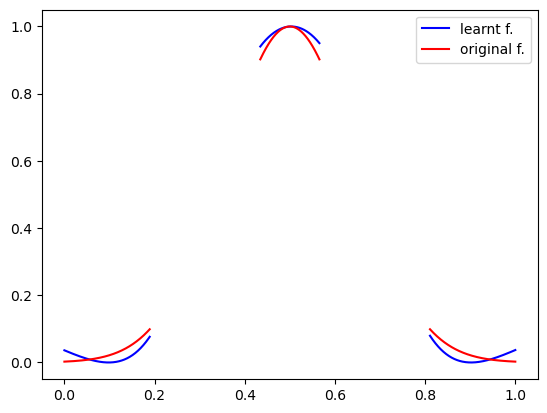

In [48]:
plt.plot(X_test2_g[0], [y[np.argmax(matrix[1])] for y in model.soft_predict(X_test2_g[0].reshape(-1,1))], color="blue", label="learnt f.")
plt.plot(X_test2_g[1], [y[np.argmax(matrix[1])] for y in model.soft_predict(X_test2_g[1].reshape(-1,1))], color="blue")
plt.plot(X_test2_g[2], [y[np.argmax(matrix[1])] for y in model.soft_predict(X_test2_g[2].reshape(-1,1))], color="blue")

plt.plot(X_test2_g[0], gaussian(X_test2_g[0], np.var(X_test)), color="red", label="original f.")
plt.plot(X_test2_g[1], gaussian(X_test2_g[1], np.var(X_test)), color="red")
plt.plot(X_test2_g[2], gaussian(X_test2_g[2], np.var(X_test)), color="red")

plt.legend(loc="upper right")

plt.show()

In [49]:
err = np.sum(step*np.abs(np.array([y[np.argmax(matrix[1])] for y in model.soft_predict(X_test.reshape(-1,1))]) - gaussian(X_test, np.var(X_test))))
err

0.044115529427672134

In [64]:
model.__repr__()[:37] + ')'

'FCM(n_clusters=3, max_iter=150, m=2.0)'

In [65]:
logger.info(log_model(model=model, model_name=model.__repr__()[:37] + ')', score=err, dataset='gaussian', serialize=True))

### Trapezoidal

In [95]:
dataset = pd.read_csv("datasets/synthetic_datasets/trapezoidal.csv").drop('Unnamed: 0', axis=1)

In [96]:
param_grid = {'n_clusters' : [2,3,4,5],
              'm' : [2,2.5,3,3.5,4]}

param_candidates = ParameterGrid(param_grid)
print(f'{len(param_candidates)} candidates')

cv = KFold(n_splits=5)

def fit_model(params, dataset):

    scores = []

    for train, test in cv.split(dataset[['X', 'y_crisp']]):
        X_train = dataset.X[train]
        X_test = dataset.X[test]
        y_train_crisp = dataset.y_crisp[train]
        y_test_crisp = dataset.y_crisp[test] 
        y_test = dataset.y[test]

        model = FCM(n_clusters=params['n_clusters'], m=params['m'])
        
        matrix = np.array([[0]*params['n_clusters']]*2)
        
        model.fit(np.array(X_train).reshape(-1,1))
        
        for pred, y in zip(model.soft_predict(np.array(X_test).reshape(-1,1)), y_test_crisp):
            matrix[y][np.argmax(pred)] += 1 
    
        i = np.argmax(matrix[1])
        
        score = sklearn.metrics.mean_squared_error(
            y_pred=np.array([y[i] for y in model.soft_predict(np.array(X_test).reshape(-1,1))]),
            y_true=np.array(y_test)
        )

        scores.append(score)

    mean_score = np.mean(scores)
        
    return [params, mean_score]

res = Parallel(n_jobs=-1, verbose=0)(delayed(fit_model)(params, dataset) for params in param_candidates)
best_result = min(res, key=lambda x: x[1])
print(best_result)

20 candidates
[{'m': 2, 'n_clusters': 3}, 0.001303794804695783]


In [97]:
model = FCM(n_clusters=best_result[0]['n_clusters'], m=best_result[0]['m'])
model.fit(np.array(dataset.X).reshape(-1,1))

In [98]:
model.soft_predict(np.array(X_test).reshape(-1,1))

array([[5.99839917e-04, 9.97128618e-01, 2.27154232e-03],
       [5.51898925e-04, 9.97354035e-01, 2.09406648e-03],
       [5.05847081e-04, 9.97571069e-01, 1.92308368e-03],
       ...,
       [9.97154955e-01, 5.88224807e-04, 2.25682013e-03],
       [9.96920990e-01, 6.37592064e-04, 2.44141757e-03],
       [9.96678760e-01, 6.88822580e-04, 2.63241695e-03]])

In [99]:
matrix = np.array([[0]*best_result[0]['n_clusters']]*2)
for pred, y in zip(model.soft_predict(np.array(dataset.X).reshape(-1,1)), dataset.y_crisp):
    matrix[y][np.argmax(pred)] += 1 

In [100]:
matrix

array([[152, 135,   0],
       [  0,   0, 736]])

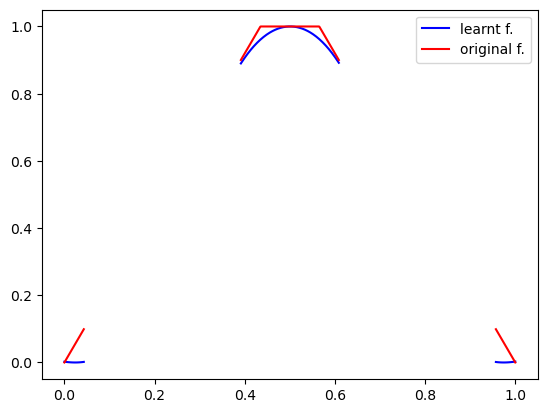

In [101]:
plt.plot(X_test2_t[0], [y[np.argmax(matrix[1])] for y in model.soft_predict(X_test2_t[0].reshape(-1,1))], color="blue", label="learnt f.")
plt.plot(X_test2_t[1], [y[np.argmax(matrix[1])] for y in model.soft_predict(X_test2_t[1].reshape(-1,1))], color="blue")
plt.plot(X_test2_t[2], [y[np.argmax(matrix[1])] for y in model.soft_predict(X_test2_t[2].reshape(-1,1))], color="blue")

plt.plot(X_test2_t[0], [trapezoidal(x) for x in X_test2_t[0]], color="red", label="original f.")
plt.plot(X_test2_t[1], [trapezoidal(x) for x in X_test2_t[1]], color="red")
plt.plot(X_test2_t[2], [trapezoidal(x) for x in X_test2_t[2]], color="red")

plt.legend(loc="upper right")

plt.show()

In [102]:
err = np.sum(step*np.abs(np.array([y[np.argmax(matrix[1])] for y in model.soft_predict(X_test.reshape(-1,1))]) - [trapezoidal(x) for x in X_test]))
err

0.10414008754692464

In [103]:
logger.info(log_model(model=model, model_name=model.__repr__()[:37] + ')', score=err, dataset='trapezoidal', serialize=True))

## Breast cancer

In [37]:
dataset_bc = load_breast_cancer()

In [38]:
def fit_model(params, dataset, train_idx, cv):

    scores = []

    for train, test in cv.split(dataset.data[train_idx], dataset.target[train_idx]):
        X_train = dataset.data[train]
        X_test = dataset.data[test]
        y_train = dataset.target[train]
        y_test = dataset.target[test] 
        
        model = FCM(n_clusters=params['n_clusters'], m=params['m'])
        
        matrix = np.array([[0]*params['n_clusters']]*2)
        
        model.fit(X_train)
        
        for pred, y in zip(model.soft_predict(X_test), y_test):
            matrix[y][np.argmax(pred)] += 1 
    
        i = np.argmax(matrix[1])
        
        preds = model.predict(X_test)
        preds = [(1 if x==i else 0) for x in preds] 

        score = accuracy_score(y_pred=preds, y_true=y_test)
        
        scores.append(score)
        
    return [params, scores]

In [39]:
param_grid = {'n_clusters' : [2,3,4,5],
              'm' : [2,2.5,3,3.5,4]}

best_results = []

param_candidates = ParameterGrid(param_grid)

outer_cv_scores = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

for train, test in tqdm.tqdm(outer_cv.split(dataset_bc.data, dataset_bc.target)):
    
    res = Parallel(n_jobs=-1, verbose=0)(delayed(fit_model)(params, dataset_bc, train, inner_cv) for params in param_candidates)
    
    best_result = max(res, key=lambda x: np.mean(x[1]))

    model = FCM(n_clusters=best_result[0]['n_clusters'], m=best_result[0]['m'])

    model.fit(dataset_bc.data[train])

    matrix = np.array([[0]*best_result[0]['n_clusters']]*2)

    for pred, y in zip(model.soft_predict(dataset_bc.data[test]), dataset_bc.target[test]):
        matrix[y][np.argmax(pred)] += 1 

    i = np.argmax(matrix[1])
    
    preds = model.predict(dataset_bc.data[test])

    preds = [(1 if x==i else 0) for x in preds]

    acc_score = accuracy_score(y_pred=preds, y_true=dataset_bc.target[test])
    outer_cv_scores.append(acc_score)

    best_results.append(best_result)
    best_models.append((model, acc_score))


score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [00:04,  1.02it/s]


In [40]:
score

[0.8752212389380531, 0.017875256948811057]

In [41]:
best_results

[[{'m': 3, 'n_clusters': 3},
  [0.8571428571428571,
   0.945054945054945,
   0.9120879120879121,
   0.8901098901098901,
   0.8901098901098901]],
 [{'m': 3, 'n_clusters': 3},
  [0.9120879120879121,
   0.8791208791208791,
   0.8901098901098901,
   0.8901098901098901,
   0.8901098901098901]],
 [{'m': 2, 'n_clusters': 3},
  [0.8901098901098901,
   0.7912087912087912,
   0.8791208791208791,
   0.9560439560439561,
   0.9340659340659341]],
 [{'m': 2, 'n_clusters': 3},
  [0.8901098901098901,
   0.8241758241758241,
   0.9120879120879121,
   0.9230769230769231,
   0.9230769230769231]],
 [{'m': 2, 'n_clusters': 3},
  [0.8913043478260869,
   0.8241758241758241,
   0.9010989010989011,
   0.9340659340659341,
   0.9120879120879121]]]

In [42]:
outer_cv_scores

[0.8421052631578947,
 0.8859649122807017,
 0.8947368421052632,
 0.8771929824561403,
 0.8761061946902655]

In [ ]:
best_models

In [44]:
logger.info(log_model(model=best_models, model_name='FCM', acc=score[0], std=score[1], dataset='breast_cancer', serialize=True))

In [171]:
X_train, X_test, y_train, y_test = train_test_split(dataset_bc.data, dataset_bc.target, random_state=42)

In [172]:
model = FCM(n_clusters=3, m=3)

In [174]:
model.fit(X_train)

In [175]:
matrix = np.array([[0]*model.n_clusters]*2)

for pred, y in zip(model.soft_predict(X_test), y_test):
    matrix[int(y)][np.argmax(pred)] += 1 

i = np.argmax(matrix[1])

In [176]:
res = model.predict(X_test)

In [177]:
res = [(1 if x==i else 0) for x in res]

In [178]:
wrong_classified = []

In [179]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [180]:
wrong_classified

[9, 12, 16, 33, 39, 63, 72, 76, 86, 91, 92, 108, 109, 112, 120, 132, 134, 138]

## MNIST

In [53]:
dataset = pd.read_json(f'datasets/MNIST/digit-{digit}/mnist_full.json')

In [69]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().astype(int).to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [70]:
def fit_model(params, X, y, train_idx, cv):

    scores = []

    for train, test in cv.split(X[train_idx], y[train_idx]):
        
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test] 
        
        model = FCM(n_clusters=params['n_clusters'], m=params['m'])
        
        matrix = np.array([[0]*params['n_clusters']]*2)
        
        model.fit(X_train)
        
        for pred, Y in zip(model.soft_predict(X_test), y_test):
            matrix[Y][np.argmax(pred)] += 1 
    
        i = np.argmax(matrix[1])
        
        preds = model.predict(X_test)
        preds = [(1 if x==i else 0) for x in preds] 

        score = accuracy_score(y_pred=preds, y_true=y_test)
        
        scores.append(score)
        
    return [params, scores]

In [71]:
param_grid = {'n_clusters' : [2,3,4,5],
              'm' : [2,2.5,3,3.5,4]}

best_results = []

param_candidates = ParameterGrid(param_grid)

outer_cv_scores = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

for train, test in tqdm.tqdm(outer_cv.split(X_train, y_train)):
    
    res = Parallel(n_jobs=-1, verbose=0)(delayed(fit_model)(params, X_train, y_train, train, inner_cv) for params in param_candidates)
    
    best_result = max(res, key=lambda x: np.mean(x[1]))

    model = FCM(n_clusters=best_result[0]['n_clusters'], m=best_result[0]['m'])

    model.fit(X_train[train])

    matrix = np.array([[0]*best_result[0]['n_clusters']]*2)

    for pred, y in zip(model.soft_predict(X_train[test]), y_train[test]):
        matrix[y][np.argmax(pred)] += 1 

    i = np.argmax(matrix[1])
    
    preds = model.predict(X_train[test])

    preds = [(1 if x==i else 0) for x in preds]

    acc_score = accuracy_score(y_pred=preds, y_true=y_train[test])
    outer_cv_scores.append(acc_score)

    best_results.append(best_result)
    best_models.append((model, acc_score))


score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [00:23,  4.76s/it]


In [72]:
score

[0.549, 0.077032460690283]

In [73]:
best_results

[[{'m': 2, 'n_clusters': 3}, [0.6125, 0.66875, 0.8, 0.75, 0.475]],
 [{'m': 4, 'n_clusters': 2}, [0.725, 0.6125, 0.75625, 0.55, 0.725]],
 [{'m': 3.5, 'n_clusters': 2}, [0.51875, 0.775, 0.55, 0.8, 0.575]],
 [{'m': 2, 'n_clusters': 2}, [0.69375, 0.6625, 0.65625, 0.58125, 0.74375]],
 [{'m': 3.5, 'n_clusters': 2}, [0.6375, 0.675, 0.75625, 0.5625, 0.65]]]

In [74]:
outer_cv_scores

[0.525, 0.69, 0.545, 0.455, 0.53]

In [ ]:
best_models

In [76]:
logger.info(log_model(model=best_models, model_name='FCM', acc=score[0], std=score[1], dataset=f'MNIST_FULL_{digit}', serialize=True))

In [111]:
model = FCM(n_clusters=3, m=3)

In [113]:
model.fit(X_train)

In [133]:
matrix = np.array([[0]*model.n_clusters]*2)

for pred, y in zip(model.soft_predict(X_test), y_test):
    matrix[int(y)][np.argmax(pred)] += 1 

i = np.argmax(matrix[1])

In [114]:
res = model.predict(X_test)

In [136]:
res = [(1 if x==i else 0) for x in res]

In [138]:
wrong_classified = []

In [139]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [ ]:
wrong_classified

In [ ]:
for index in wrong_classified:
    arr = X_test[index].reshape(28,28)
    img = Image.fromarray(np.uint8(arr) , 'L')
    display(img.resize((200, 200)))

### ResNet50 inputs

In [63]:
dataset = pd.read_json(f"./datasets/MNIST/digit-{digit}/mnist_full_cnn.json")

In [94]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().astype(int).to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [95]:
def fit_model(params, X, y, train_idx, cv):

    scores = []

    for train, test in cv.split(X[train_idx], y[train_idx]):
        
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test] 
        
        model = FCM(n_clusters=params['n_clusters'], m=params['m'])
        
        matrix = np.array([[0]*params['n_clusters']]*2)
        
        model.fit(X_train)
        
        for pred, Y in zip(model.soft_predict(X_test), y_test):
            matrix[Y][np.argmax(pred)] += 1 
    
        i = np.argmax(matrix[1])
        
        preds = model.predict(X_test)
        preds = [(1 if x==i else 0) for x in preds] 

        score = accuracy_score(y_pred=preds, y_true=y_test)
        
        scores.append(score)
        
    return [params, scores]

In [96]:
param_grid = {'n_clusters' : [2,3,4,5],
              'm' : [2,2.5,3,3.5,4]}

best_results = []

param_candidates = ParameterGrid(param_grid)

outer_cv_scores = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

for train, test in tqdm.tqdm(outer_cv.split(X_train, y_train)):
    
    res = Parallel(n_jobs=-1, verbose=0)(delayed(fit_model)(params, X_train, y_train, train, inner_cv) for params in param_candidates)
    
    best_result = max(res, key=lambda x: np.mean(x[1]))

    model = FCM(n_clusters=best_result[0]['n_clusters'], m=best_result[0]['m'])

    model.fit(X_train[train])

    matrix = np.array([[0]*best_result[0]['n_clusters']]*2)

    for pred, y in zip(model.soft_predict(X_train[test]), y_train[test]):
        matrix[y][np.argmax(pred)] += 1 

    i = np.argmax(matrix[1])
    
    preds = model.predict(X_train[test])

    preds = [(1 if x==i else 0) for x in preds]

    acc_score = accuracy_score(y_pred=preds, y_true=y_train[test])
    outer_cv_scores.append(acc_score)

    best_results.append(best_result)
    best_models.append((model, acc_score))


score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [04:22, 52.49s/it]


In [97]:
logger.info(log_model(model=best_models, model_name='FCM', acc=score[0], std=score[1], dataset=f'MNIST_FULL_CNN_{digit}', serialize=True))

In [98]:
score

[0.7060000000000001, 0.02922327839240489]

In [99]:
outer_cv_scores

[0.74, 0.71, 0.735, 0.67, 0.675]

In [100]:
best_results

[[{'m': 2, 'n_clusters': 2}, [0.74375, 0.66875, 0.78125, 0.68125, 0.7]],
 [{'m': 3, 'n_clusters': 4}, [0.71875, 0.675, 0.7875, 0.6875, 0.7125]],
 [{'m': 3, 'n_clusters': 4}, [0.71875, 0.69375, 0.75, 0.7, 0.71875]],
 [{'m': 3, 'n_clusters': 4}, [0.7125, 0.69375, 0.75625, 0.7, 0.7125]],
 [{'m': 2.5, 'n_clusters': 2}, [0.74375, 0.69375, 0.7625, 0.69375, 0.6875]]]

In [ ]:
best_models

In [150]:
model = FCM(n_clusters=2, m=2)

In [151]:
model.fit(X_train)

In [152]:
matrix = np.array([[0]*model.n_clusters]*2)

for pred, y in zip(model.soft_predict(X_test), y_test):
    matrix[int(y)][np.argmax(pred)] += 1 

i = np.argmax(matrix[1])

In [153]:
res = model.predict(X_test)

In [154]:
res = [(1 if x==i else 0) for x in res]

In [155]:
wrong_classified = []

In [156]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [ ]:
wrong_classified

In [ ]:
for index in wrong_classified:
    arr = np.array(pd.read_json('mnist.json').X_test.dropna().to_list())[index].reshape(28,28)
    img = Image.fromarray(np.uint8(arr) , 'L')
    display(img.resize((200, 200)))

# <span style="color:red"> SVM

## Synthetic datasets

### Gaussian

In [86]:
dataset = pd.read_csv("datasets/synthetic_datasets/gaussian.csv").drop('Unnamed: 0', axis=1)

In [94]:
param_grid_1 = {'kernel' : ['poly'],
                'C' : np.logspace(-2,0,3),
                'degree' : [2,3,4]}

param_grid_2 = {'kernel' : ['rbf', 'sigmoid'],
                'C' : np.logspace(-2,1,4),
                'gamma' : ['auto', 'scale'] + list(np.logspace(-2,0,3))}

param_grid_3 = {'kernel' : ['linear'],
                'C' : np.logspace(-2,1,4)}

model = SVR()

clf = GridSearchCV(model, param_grid=[param_grid_1,param_grid_2,param_grid_3], n_jobs=-1, refit=True, verbose=1)

clf.fit(np.array(dataset.X).reshape(-1,1), list(dataset.y))

Fitting 5 folds for each of 53 candidates, totalling 265 fits


GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': array([0.01, 0.1 , 1.  ]), 'degree': [2, 3, 4],
                          'kernel': ['poly']},
                         {'C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                          'gamma': ['auto', 'scale', 0.01, 0.1, 1.0],
                          'kernel': ['rbf', 'sigmoid']},
                         {'C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                          'kernel': ['linear']}],
             verbose=1)

In [78]:
model = clf.best_estimator_

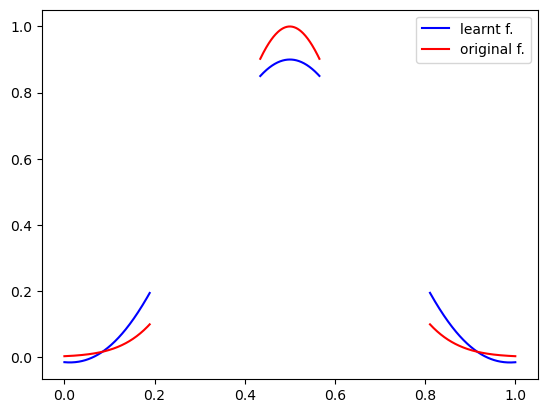

In [79]:
plt.plot(X_test2_g[0], model.predict(X_test2_g[0].reshape(-1,1)), color="blue", label="learnt f.")
plt.plot(X_test2_g[1], model.predict(X_test2_g[1].reshape(-1,1)), color="blue")
plt.plot(X_test2_g[2], model.predict(X_test2_g[2].reshape(-1,1)), color="blue")

plt.plot(X_test2_g[0], gaussian(X_test2_g[0], np.var(X_test)), color="red", label="original f.")
plt.plot(X_test2_g[1], gaussian(X_test2_g[1], np.var(X_test)), color="red")
plt.plot(X_test2_g[2], gaussian(X_test2_g[2], np.var(X_test)), color="red")

plt.legend(loc="upper right")

plt.show()

In [80]:
err = np.sum(step*np.abs(model.predict(X_test.reshape(-1,1)) - gaussian(X_test, np.var(X_test))))
err

0.06763537651071772

In [81]:
logger.info(log_model(model=model, score=err, dataset='gaussian', serialize=True))

### Trapezoidal

In [4]:
dataset = pd.read_csv("datasets/synthetic_datasets/trapezoidal.csv").drop('Unnamed: 0', axis=1)

In [11]:
param_grid_1 = {'kernel' : ['poly'],
                'C' : np.logspace(-2,0,3),
                'degree' : [2,3]}

param_grid_2 = {'kernel' : ['rbf', 'sigmoid'],
                'C' : np.logspace(-2,1,4),
                'gamma' : ['auto', 'scale'] + list(np.logspace(-2,0,3))}

param_grid_3 = {'kernel' : ['linear'],
                'C' : np.logspace(-2,1,4)}

model = SVR(max_iter=10**6)

clf = GridSearchCV(model, param_grid=[param_grid_1, param_grid_2, param_grid_3], n_jobs=-1, refit=True, verbose=1)

clf.fit(np.array(dataset.X).reshape(-1,1), list(dataset.y))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/matteo/miniconda3/envs/testing_env/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(estimator=SVR(max_iter=1000000), n_jobs=-1,
             param_grid=[{'C': array([0.01, 0.1 , 1.  ]), 'degree': [2, 3],
                          'kernel': ['poly']},
                         {'C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                          'gamma': ['auto', 'scale', 0.01, 0.1, 1.0],
                          'kernel': ['rbf', 'sigmoid']},
                         {'C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                          'kernel': ['linear']}],
             verbose=1)

In [12]:
model = clf.best_estimator_

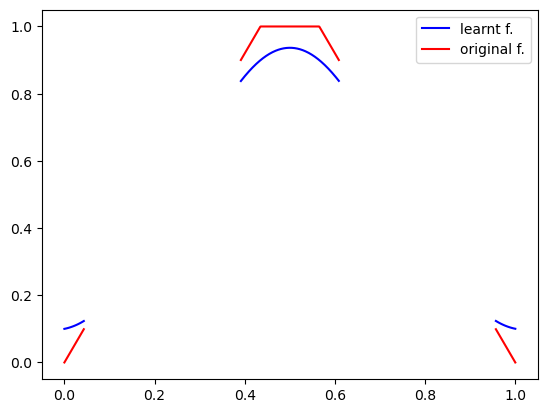

In [13]:
plt.plot(X_test2_t[0], model.predict(X_test2_t[0].reshape(-1,1)), color="blue", label="learnt f.")
plt.plot(X_test2_t[1], model.predict(X_test2_t[1].reshape(-1,1)), color="blue")
plt.plot(X_test2_t[2], model.predict(X_test2_t[2].reshape(-1,1)), color="blue")

plt.plot(X_test2_t[0], [trapezoidal(x) for x in X_test2_t[0]], color="red", label="original f.")
plt.plot(X_test2_t[1], [trapezoidal(x) for x in X_test2_t[1]], color="red")
plt.plot(X_test2_t[2], [trapezoidal(x) for x in X_test2_t[2]], color="red")

plt.legend(loc="upper right")

plt.show()

In [14]:
err = np.sum(step*np.abs(model.predict(X_test.reshape(-1,1)) - [trapezoidal(x) for x in X_test]))
err

0.05804809373314501

In [15]:
logger.info(log_model(model=model, score=err, dataset='trapezoidal', serialize=True))

## Breast cancer

In [5]:
dataset_bc = load_breast_cancer()

In [6]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

model = SVC()

param_grid_1 = {'kernel' : ['poly'],
                'C' : np.logspace(-2,0,3),
                'degree' : [2,3,4]}

param_grid_2 = {'kernel' : ['rbf', 'sigmoid'],
                'C' : np.logspace(-2,1,4),
                'gamma' : ['auto', 'scale'] + list(np.logspace(-2,0,3))}

param_grid_3 = {'kernel' : ['linear'],
                'C' : np.logspace(-2,1,4)}

for train, test in tqdm.tqdm(outer_cv.split(dataset_bc.data, dataset_bc.target)):

    clf = GridSearchCV(estimator=model, param_grid=[param_grid_1, 
                                                    param_grid_2, 
                                                    param_grid_3], 
                       cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(dataset_bc.data[train], dataset_bc.target[train])

    m = clf.best_estimator_

    outer_cv_params.append(m.__repr__())
    acc_score = accuracy_score(y_pred=m.predict(dataset_bc.data[test]), y_true=dataset_bc.target[test])
    outer_cv_scores.append(acc_score)
    best_models.append((m, acc_score))


score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [00:32,  6.43s/it]


In [7]:
score

[0.9455519329296692, 0.020249767815305863]

In [8]:
outer_cv_scores

[0.9385964912280702,
 0.9298245614035088,
 0.9736842105263158,
 0.9210526315789473,
 0.9646017699115044]

In [9]:
outer_cv_params

["SVC(C=0.1, kernel='linear')",
 "SVC(kernel='linear')",
 "SVC(C=10.0, kernel='linear')",
 "SVC(kernel='linear')",
 "SVC(C=10.0, kernel='linear')"]

In [10]:
best_models

[(SVC(C=10.0, kernel='linear'), 0.9736842105263158),
 (SVC(C=10.0, kernel='linear'), 0.9646017699115044),
 (SVC(C=0.1, kernel='linear'), 0.9385964912280702),
 (SVC(kernel='linear'), 0.9298245614035088),
 (SVC(kernel='linear'), 0.9210526315789473)]

In [11]:
logger.info(log_model(model=best_models, model_name='SVM', acc=score[0], std=score[1], dataset='breast_cancer', serialize=True))

In [92]:
X_train, X_test, y_train, y_test = train_test_split(dataset_bc.data, dataset_bc.target, random_state=42)

In [93]:
model = SVC(kernel='linear')

In [94]:
model.fit(X_train, y_train)

SVC(kernel='linear')

In [95]:
model.score(X_test, y_test)

0.958041958041958

In [96]:
res = model.predict(X_test)

In [97]:
wrong_classified = []

In [98]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [99]:
wrong_classified

[20, 58, 77, 82, 112, 120]

## MNIST

In [72]:
dataset = pd.read_json(f'datasets/MNIST/digit-{digit}/mnist_full.json')

In [77]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [78]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

model = SVC()

param_grid_1 = {'kernel' : ['poly'],
                'C' : np.logspace(-2,0,3),
                'degree' : [2,3,4]}

param_grid_2 = {'kernel' : ['rbf', 'sigmoid'],
                'C' : np.logspace(-2,1,4),
                'gamma' : ['auto', 'scale'] + list(np.logspace(-2,0,3))}

param_grid_3 = {'kernel' : ['linear'],
                'C' : np.logspace(-2,1,4)}

for train, test in tqdm.tqdm(outer_cv.split(X_train, y_train)):

    clf = GridSearchCV(estimator=model, param_grid=[param_grid_1, 
                                                    param_grid_2, 
                                                    param_grid_3], 
                       cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(X_train[train], y_train[train])

    m = clf.best_estimator_

    outer_cv_params.append(m.__repr__())
    acc_score = accuracy_score(y_pred=m.predict(X_train[test]), y_true=y_train[test])
    outer_cv_scores.append(acc_score)
    best_models.append((m, acc_score))


score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [01:55, 23.20s/it]


In [79]:
score

[0.959, 0.013928388277184131]

In [80]:
outer_cv_params

['SVC(C=10.0)', 'SVC(C=10.0)', 'SVC(C=10.0)', 'SVC(C=10.0)', 'SVC(C=10.0)']

In [81]:
outer_cv_scores

[0.975, 0.945, 0.965, 0.94, 0.97]

In [82]:
best_models

[(SVC(C=10.0), 0.975),
 (SVC(C=10.0), 0.97),
 (SVC(C=10.0), 0.965),
 (SVC(C=10.0), 0.945),
 (SVC(C=10.0), 0.94)]

In [83]:
logger.info(log_model(model=best_models, model_name='SVM', acc=score[0], std=score[1], dataset=f'MNIST_FULL_{digit}', serialize=True))

In [11]:
model = SVC(C=10)

In [12]:
model.fit(X_train, y_train)

SVC(C=10)

In [13]:
res = model.predict(X_test)

In [14]:
wrong_classified = []

In [15]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [16]:
wrong_classified

[33, 40, 81, 94, 97, 104, 137, 161, 162, 272]

In [ ]:
for index in wrong_classified:
    arr = X_test[index].reshape(28,28)
    img = Image.fromarray(np.uint8(arr) , 'L')
    print('Label:', y_test[index])
    display(img.resize((200, 200)))
    print()

### ResNet50 inputs

In [80]:
dataset = pd.read_json(f"./datasets/MNIST/digit-{digit}/mnist_full_cnn.json")

In [102]:
X_train = np.array(dataset.X_train.dropna().to_list())
y_train = np.array(dataset.y_train.dropna().to_list())
X_test = np.array(dataset.X_test.to_list())
y_test = np.array(dataset.y_test.to_list())

In [103]:
param_grid_1 = {'kernel' : ['poly'],
                'C' : np.logspace(-2,0,3),
                'degree' : [2,3,4]}

param_grid_2 = {'kernel' : ['rbf', 'sigmoid'],
                'C' : np.logspace(-2,1,4),
                'gamma' : ['auto', 'scale'] + list(np.logspace(-2,0,3))}

param_grid_3 = {'kernel' : ['linear'],
                'C' : np.logspace(-2,1,4)}

parameters = [param_grid_1, param_grid_2, param_grid_3]

In [104]:
model = SVC()

In [105]:
outer_cv_scores = []
outer_cv_params = []
inner_cv = StratifiedKFold(n_splits=5)
outer_cv = StratifiedKFold(n_splits=5)
best_models = []

for train, test in tqdm.tqdm(outer_cv.split(X_train, y_train)):

    clf = GridSearchCV(estimator=model, param_grid=parameters, 
                       cv=inner_cv, n_jobs=-1, verbose=0, refit=True)
    
    clf.fit(X_train[train], y_train[train])

    m = clf.best_estimator_

    outer_cv_params.append(m.__repr__())
    acc_score = accuracy_score(y_pred=m.predict(X_train[test]), y_true=y_train[test])
    outer_cv_scores.append(accuracy_score(y_pred=m.predict(X_train[test]), y_true=y_train[test]))
    best_models.append((m, acc_score))


score = [np.mean(outer_cv_scores), np.std(outer_cv_scores)]
best_models = sorted(best_models, key=lambda x:x[1], reverse=True)

5it [01:39, 19.96s/it]


In [106]:
logger.info(log_model(model=best_models, model_name='SVM', acc=score[0], std=score[1], dataset=f'MNIST_FULL_CNN_{digit}', serialize=True))

In [107]:
score

[0.942, 0.007483314773547853]

In [108]:
outer_cv_scores

[0.94, 0.94, 0.93, 0.95, 0.95]

In [109]:
outer_cv_params

['SVC(C=10.0)',
 'SVC(C=10.0)',
 "SVC(C=0.01, kernel='linear')",
 'SVC(C=10.0)',
 'SVC(C=10.0)']

In [110]:
best_models

[(SVC(C=10.0), 0.95),
 (SVC(C=10.0), 0.95),
 (SVC(C=10.0), 0.94),
 (SVC(C=10.0), 0.94),
 (SVC(C=0.01, kernel='linear'), 0.93)]

In [74]:
model = SVC(C=0.1, kernel='linear')

In [75]:
model.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [76]:
res = model.predict(X_test)

In [77]:
wrong_classified = []

In [78]:
for i in range(len(X_test)):
    if res[i] != y_test[i]:
        wrong_classified.append(i)

In [79]:
wrong_classified

[14,
 15,
 22,
 63,
 104,
 114,
 119,
 124,
 125,
 131,
 135,
 147,
 158,
 173,
 195,
 199,
 202,
 204,
 211,
 253,
 272,
 291]

In [ ]:
import numpy as np
from PIL import Image

for index in wrong_classified:
    arr = np.array(pd.read_json('mnist.json').X_test.dropna().to_list())[index].reshape(28,28)
    img = Image.fromarray(np.uint8(arr) , 'L')
    display(img.resize((200, 200)))